In [1]:
import sys
home = '/media/data0/nkudryas/arch/CopulaGP/'
sys.path.insert(0, home)
import bvcopula

home = '/home/nina/CopulaGP/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

import svgutils.compose as sc
from IPython.display import SVG
from matplotlib.ticker import FormatStrFormatter
from matplotlib import collections  as mc

# Add Gaussian baseline

CPU times: user 13.4 s, sys: 9.42 ms, total: 13.4 s
Wall time: 17 s


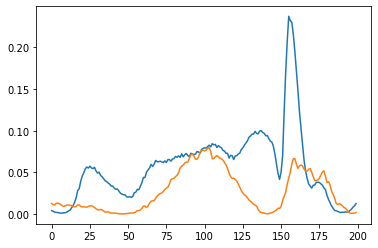

In [2]:
n1,n2 = -2,60

import torch
device='cuda:0'
with open(f"/home/nina/CopulaGP/results/ex_{n1}_{n2}_serialized.pkl","rb") as f:
    data = pkl.load(f)
train_x = torch.tensor(data['X'],device=device).float()
train_y = torch.tensor(data['Y'],device=device).float()

import bvcopula

likelihoods = [bvcopula.GaussianCopula_Likelihood()]
waic, model = bvcopula.infer(likelihoods,train_x,train_y,device=device)

test_x = torch.linspace(0,1,200,device=device).float()
%time MI = model.MI(test_x,sem_tol=0.01,f_size=25,mc_size=1000)

plt.plot(data['MI'][1])
plt.plot(-MI[1].cpu().numpy())

In [3]:
data['gauss_MI'] = [-mi.cpu().numpy() for mi in MI] 
with open(f"/home/nina/CopulaGP/results/ex_{n1}_{n2}_serialized.pkl","wb") as f:
    pkl.dump(data,f)
1-data['gauss_MI'][1].mean()/data['MI'][1].mean()

0.5255449116230011

In [4]:
n1,n2 = 3,63
with open(f"/home/nina/CopulaGP/results/ex_{n1}_{n2}_serialized.pkl","rb") as f:
    data = pkl.load(f)
1-data['gauss_MI'][1].mean()/data['MI'][1].mean()

0.42615145444869995

In [5]:
with open(f"{home}/results/MI_subpop_MINE_C.pkl","rb") as f:
    [Ns,I] = pkl.load(f)
I[0]/2.17

0.44876233561878615

In [6]:
with open(f"{home}/results/HYgX_C.pkl","rb") as f:
    data = pkl.load(f)

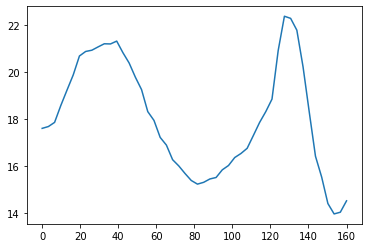

In [7]:
plt.plot(data[0]*160,-data[1])

In [8]:
with open(f"{home}/results/singleH.pkl","rb") as f: #single variable BI_KSG:(MI,H(Y|X)) from standard data
    singleH = pkl.load(f)
# with open(f"{home}/results/MI_subpop_MINE.pkl","rb") as f:
#     [Ns,I] = pkl.load(f)

In [9]:
with open(f"{home}/results/HYgX_trunc_C.pkl","rb") as f:
    [NsC,xC,HC] = pkl.load(f)
with open(f"{home}/results/HYgX_trunc_U.pkl","rb") as f:
    [NsU,xU,HU] = pkl.load(f)
assert np.all(NsC==NsU)
Ns = 109-NsC

In [10]:
MI = [Hrs.mean()-Hr.mean() for Hrs,Hr in zip(HC,HU)]

In [11]:
import torch
import bvcopula

n1, n2 = -2,60

device = "cuda:0"
with open(f"{home}/results/ex_{n1}_{n2}_serialized.pkl","rb") as f:
    data = pkl.load(f)
train_x = torch.tensor(data['X'],device=device).float()
train_y = torch.tensor(data['Y'],device=device).float()

In [12]:
from torch import Tensor
def _generate_test_samples(model: bvcopula.Mixed_GPInferenceModel, test_x: Tensor) -> Tensor:
    
    with torch.no_grad():
        output = model(test_x)

    #generate some samples
    model.eval()
    with torch.no_grad(), num_likelihood_samples(1):
        gplink = model.likelihood.gplink_function
        likelihoods = model.likelihood.likelihoods
        copulas = [lik.copula for lik in likelihoods]
        rotations = [lik.rotation for lik in likelihoods]
        thetas, mixes = gplink(output.mean)
        test_y = model.likelihood.copula(thetas,mixes,
                    copulas, rotations=rotations,
                    theta_sharing=model.likelihood.theta_sharing).rsample()
        Y_sim = test_y.cpu().detach().numpy()

    return Y_sim

def _get_pearson(X: Tensor, Y: Tensor):
    from scipy.stats import pearsonr

    X = X.squeeze()
    assert np.isclose(X.max(),1.0,atol=1e-4)
    assert np.isclose(X.min(),0.0,atol=1e-4)
    N = int(160/2.5)
    x = np.linspace(0,1,N)
    p = np.empty(N)

    for b in range(N):
        dat = Y[(X>b*(1./N)) & (X<(b+1)*(1./N))]
        if len(dat)>1:
            p[b] = pearsonr(*dat.T)[0]
        
    p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    

    return np.stack([x[2:-1]*160,p])

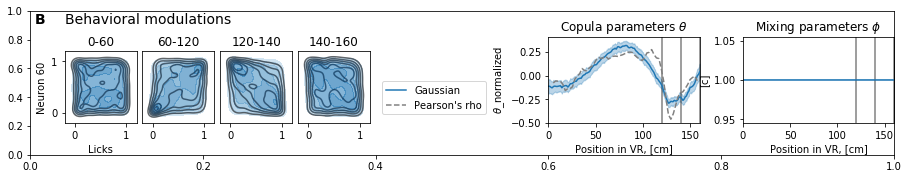

In [13]:
import utils
    
name1, name2 = f"Neuron {data['n1']}", f"Neuron {data['n2']}"
    
name1 = 'Licks'

# visualize the result
from utils import plot_conf as conf2
from gpytorch.settings import num_likelihood_samples
X = data['X']
Y = data['Y']
fig = plt.figure(figsize=(12,2))

ax0 = fig.add_axes([0,0,1,1])

b_mrg = 0.22
top_axes = (fig.add_axes([0.6, b_mrg, 0.175, 0.6]),
            fig.add_axes([0.825, b_mrg,0.175, 0.6]))
bottom_axes = np.array([fig.add_axes([0.04,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.13,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.22,b_mrg,0.5/6,0.5]),
                        fig.add_axes([0.31,b_mrg,0.5/6,0.5])])

for a in top_axes:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)    

# define test set (optionally on GPU)
NSamp = X.shape[0] #by defauls generate as many samples as in training set
testX = np.linspace(0,1,NSamp)
test_x = torch.tensor(testX).float().to(device=device)

Y_sim = _generate_test_samples(model, test_x)

utils.Plot_MixModel_Param_MCMC(top_axes,model,test_x,testX*160,rho=_get_pearson(X,Y),title='')
top_axes[0].set_title(r'Copula parameters $\theta$')
top_axes[1].set_title('Mixing parameters $\phi$')
top_axes[0].legend(loc=(-1.1,0.1))
top_axes[1].legend().set_visible(False)
# top_axes[0].set_ylabel(r"$\theta\_{normalized}$",labelpad=-1)

bottom_axes[0].set_ylabel(name2)
bottom_axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
# fig.text(0.005,0.91,"A",fontweight="bold",fontsize=14)
# fig.text(0.040,0.91,"Inter-neuronal noise correlations",fontsize=14)
fig.text(0.005,0.91,"B",fontweight="bold",fontsize=14)
fig.text(0.040,0.91,"Behavioral modulations",fontsize=14)
utils.Plot_Copula_Density(bottom_axes, testX.squeeze()*160, Y_sim.squeeze(), interval_ends, shade=True)
utils.Plot_Copula_Density(bottom_axes, X.squeeze()*160, Y, interval_ends, shade=False, color='#073763ff')
for b in bottom_axes[1:]:
    b.set_yticks([])
bottom_axes[0].set_yticks([0,1])
    
plt.subplots_adjust(wspace=0.5)
fig.savefig(f"{home}/results/example2.pdf")

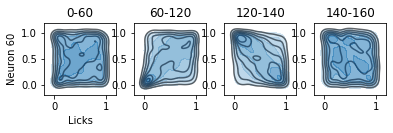

In [14]:
# visualize the result
fig = plt.figure(figsize=(5, 2))

bottom_axes = np.array([fig.add_axes([0,0,0.2,0.5]),
               fig.add_axes([0.25,0,0.2,0.5]),
               fig.add_axes([0.5,0,0.2,0.5]),
               fig.add_axes([0.75,0,0.2,0.5])])

plt.subplots_adjust(hspace=0.5)

bottom_axes[0].set_ylabel(name2)
bottom_axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
utils.Plot_Copula_Density(bottom_axes, data['Xs'].squeeze()*160, data['Ys'].squeeze(), 
                          interval_ends, shade=True)
utils.Plot_Copula_Density(bottom_axes, data['X'].squeeze()*160, data['Y'], 
                          interval_ends, shade=False, color='#073763ff')

plt.subplots_adjust(wspace=0.5)

# R^2

In [15]:
ints = np.array([0,60,120,140,160])/160
R = []
N, M = 20, 100
mesh = torch.stack(torch.meshgrid([torch.linspace(0.,1.,M+2)[1:-1], 
                                   torch.linspace(0.,1.,N+2)[1:-1]]),axis=-1).reshape(-1,2).to(device)
for i in range(len(ints)-1):
    mask = (data['X']>ints[i]) & (data['X']<ints[i+1])
    S = data['Y'][mask]
    u_cdf = np.cumsum(np.histogram2d(*S.T,bins=[M+1,N])[0],axis=0)
    ecdf = u_cdf[:-1] / u_cdf.max(axis=0)
    # plt.imshow(ecdf)
    mean = data['X'][mask].mean()
    test_x = (torch.ones(M*N)*mean).float().cuda(device=device)
    with torch.no_grad():
        f = model(test_x).mean
        copula = model.likelihood.get_copula(f)
    ccdf = copula.ccdf(mesh).detach().cpu().numpy().reshape(M,N)
    # plt.imshow(ccdf)
    # base = np.repeat((np.linspace(0,1,N+2)[1:-1]).reshape(-1,1),N,axis=1)
    var_exp = 1 - ((ecdf-ccdf)**2).sum(axis=0)/((ecdf-0.5)**2).sum(axis=0)
    R.append(var_exp.mean())
# plt.plot(np.linspace(0,1,N+2)[1:-1])
# plt.plot(ecdf[:,-4])
# plt.plot(ccdf[:,-4])
# plt.plot(base[:,-4])

In [17]:
# R1 = R
# R
# print(R)
[R1,R2] = [[0.9860019722068722, 0.9729762509342, 0.9448647468109408, 0.9821123175158591],
 [0.9885824997929535,
  0.983195342980131,
  0.9834448477631075,
  0.9790247773014025]]

In [18]:
path = '/home/nina/VRData/Processing/pkls'
animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
with open(f"{path}/{exp_pref}_signals.pkl",'rb') as f:
    signal_pkl = pkl.load(f)
with open(f"{path}/{exp_pref}_behaviour.pkl",'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))

[26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


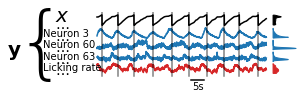

In [27]:
from scipy.stats import gaussian_kde
from matplotlib.patches import Polygon

fig = plt.figure(figsize = (4,1))

mask = np.arange(5000,6500)
def normalise(signal):
    return (signal - signal.min())/(signal.max() - signal.min())

def plot_trace(ax,x,signal,mask,shift,c='C0'):
    ax.plot(x,normalise(signal[mask])*1.6-0.3+shift,color=c)
    kde = gaussian_kde(normalise(signal))
    t = np.linspace(0,1,1000)
    y = np.concatenate(([0],kde(t),[0]))
    y = 1000*20*y/y.sum()
    t = np.concatenate(([0],t,[1]))*1.5-0.25
    pl = Polygon(np.stack([x.max()+40+y,t+shift],axis=-1),True,color=c)
    ax.add_patch(pl)
#         #[x.max()/3000,shift/6,100/3000,1/6])

def plot_all_traces(ax):

    x = (mask-5000)/1.5+500
    plot_trace(ax,x,signal_pkl['signals_fissa'][3],mask,5.2)
    plot_trace(ax,x,signal_pkl['signals_fissa'][60],mask,3.4)
    plot_trace(ax,x,signal_pkl['signals_fissa'][63],mask,1.6)
    plot_trace(ax,x,behaviour_pkl['fat_licks'],mask,-.2,c='C3')
    
    plot_trace(ax,x,behaviour_pkl['position'],mask,7.2,c='k')

    trials = behaviour_pkl['trials'][mask]
    print(trials[1:][trials[1:] - trials[:-1] == 1]) #next
    pos_change = np.arange(len(trials[:-1]))[trials[1:] - trials[:-1]==1]
    for p in pos_change:
        plt.axvline(p/1.5+500, ymin=0.1, color='k',alpha=0.5)
    
    x = (mask[830:830+24*5]-5000)/1.5+500
    ax.plot(x,x*0-1.5,color='k')
    ax.text(x[15],-2.8,'5s')
    
    ax.text(-30,2.3,'$\mathbf{y}$',fontsize=20)
    ax.text(20,0.4,'{',fontsize=80,fontweight='ultralight')
    ax.text(250,7.5,'$x$',fontsize=20)
    
    ax.text(180,5.3,'Neuron 3')
    ax.text(180,3.5,'Neuron 60')
    ax.text(180,1.8,'Neuron 63')
    ax.text(180,0.1,'Licking rate')
    for i in [-0.6,1.15,2.9,4.65,6.4]:
        ax.text(250,i,'$\ldots$',fontsize=14)
        
    ax.set_xlim(0,1700)
#         plt.axvline(p+1300,color='k',alpha=0.5)
    # behaviour_pkl

#     x = mask-3700
#     plot_trace(ax,x,signal_pkl['signals_transformed'][3],mask,3.6)
#     plot_trace(ax,x,signal_pkl['signals_transformed'][60],mask,2.4)
#     plot_trace(ax,x,signal_pkl['signals_transformed'][63],mask,1.2)
#     plot_trace(ax,x,behaviour_pkl['transformed_licks'],mask,+0,c='C3')
#     plot_trace(ax,x,behaviour_pkl['position'],mask,-2,c='k')
    
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
plot_all_traces(ax)

[26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


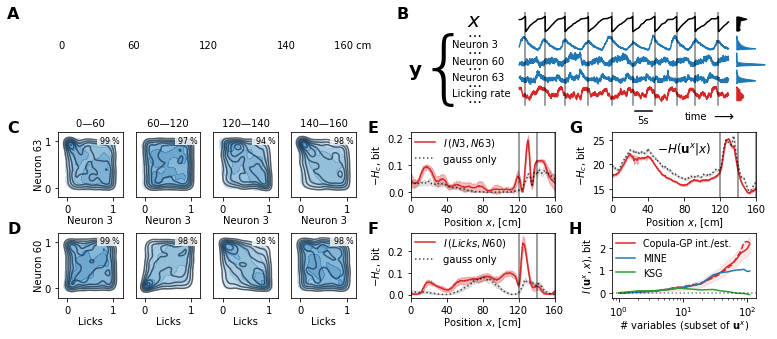

In [44]:
# fig, (trunc,subpop,Hrs) = plt.subplots(1,3,figsize=(15,2))

fig_width, fig_height = 10.2, 4.5
aspect = fig_width/fig_height
fig = plt.figure(figsize=(fig_width,fig_height))

l_mrg, b_mrg = 0.5/fig_width, aspect*0.4/fig_width
block_size = 2.8/fig_width
dens_size = .9/fig_width
plot_width, plot_height = 2.0/fig_width, dens_size*aspect
dens_y = b_mrg# + 1.4/fig_height
dens_blockX = dens_size*1.2
dens_blockY = 1.4/fig_height
MI_shift = 1.75*block_size

# ax0 = fig.add_axes([0,0,1,1])

def plot_exp(fig,n1,n2,R,n,label):
        
    with open(f"{home}/results/ex_{n1}_{n2}_serialized.pkl","rb") as f:
        data = pkl.load(f)
        
    name1, name2 = f"Neuron {data['n1']}", f"Neuron {data['n2']}"
    if n1==-2:
        name1 = 'Licks'
    
    ax_list = []
    for i in range(4):
        ax_list.append(fig.add_axes([l_mrg+i*dens_blockX,dens_y+dens_blockY*n,dens_size,dens_size*aspect]))
        if i>0:
            ax_list[-1].set_yticks([],[])
    utils.Plot_Copula_Density(np.array(ax_list), data['Xs'].squeeze()*160, data['Ys'].squeeze(), 
                              interval_ends, shade=True)
    utils.Plot_Copula_Density(np.array(ax_list), data['X'].squeeze()*160, data['Y'], 
                              interval_ends, shade=False, color='#073763ff')

    titles = ["{}⁠—{}".format(s,e) for s,e in zip(interval_ends[:-1],interval_ends[1:])]
    for i in range(4):
        if n!=1:
            ax_list[i].set_title('')
        else:
            ax_list[i].set_title(titles[i],fontsize=10)
        ax_list[i].set_xlabel(name1,labelpad=1,fontsize=10)
        ax_list[i].text(0.65,0.97,f' ${R[i]*100:.0f}\,\%$', fontsize=8,
                        bbox={'facecolor':'white', 'edgecolor':'none', 'alpha':0.8, 'pad':0.3})
    ax_list[0].set_ylabel(name2,labelpad=1,fontsize=10)
#     ax_list[0].set_xlabel(name1,labelpad=1)
    
    ax_list[0].xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax_list[0].yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax_list[0].set_yticks([0,1],minor=False)
    ax_list[0].set_yticklabels([0,1])

    MI = fig.add_axes([l_mrg + MI_shift,dens_y+dens_blockY*n,plot_width,plot_height])
    MI.plot(data["MI"][0],data["MI"][1],color='C3', label = label)
    MI.fill_between(data["MI"][0],(data["MI"][1]-data["MI"][2]),
                     (data["MI"][1]+data["MI"][2]),
                     alpha=0.3,color='C3')#,label="MI={:.2}±{:.1}".format(MI,dMI))
    # MI.set_title('MI between {} and {}'.format(name1,name2))
#     if n==0:
    MI.plot(data["MI"][0],data["gauss_MI"][1],color='k', label = 'gauss only',linestyle='dotted',alpha=0.7)
    MI.fill_between(data["MI"][0],(data["gauss_MI"][1]-data["gauss_MI"][2]),
                     (data["gauss_MI"][1]+data["gauss_MI"][2]),
                     alpha=0.1,color='k')
    MI.set_xlabel('Position $x$, [cm]',labelpad=1)
    for x in [120,140,160]:
        MI.axvline(x, color='black', alpha=0.5)
    MI.set_ylabel('$-H_c$, bit')
    MI.set_xlim(0,160)
    MI.set_xticks(np.arange(0,161,40),minor=False)
    MI.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    MI.legend(fontsize = 10, frameon=False,loc=(0,0.45))
    
# plot_exp(fig,14,23,2)
plot_exp(fig,3,63,R1,1,"$I\,(N3, N63)$")
plot_exp(fig,-2,60,R2,0,"$I\,(Licks, N60)$")

##################################################################

fig.text(2.435*dens_blockX,dens_y+2*dens_blockY+0.22*plot_height,"   Reward",fontsize=12, color='white')
# fig.text(3.45*dens_blockX,dens_y+2*dens_blockY+0.1*plot_height,"   Late\n reward",fontsize=14, color='white')
fig.text(-0.02,dens_y+2*dens_blockY+plot_height*1.2,"A",fontsize=16,fontweight='bold')
fig.text(MI_shift+0.03,dens_y+2*dens_blockY+plot_height*1.2,"B",fontsize=16,fontweight='bold')
fig.text(-0.02,dens_y+dens_blockY+plot_height,"C",fontsize=16,fontweight='bold')
fig.text(-0.02,dens_y+plot_height,"D",fontsize=16,fontweight='bold')

fig.text(l_mrg,dens_y+1.83*dens_blockY+plot_height,'0')
fig.text(l_mrg+1*dens_blockX-0.012,dens_y+1.83*dens_blockY+plot_height,'60')
fig.text(l_mrg+2*dens_blockX-0.02,dens_y+1.83*dens_blockY+plot_height,'120')
fig.text(l_mrg+3*dens_blockX-0.02,dens_y+1.83*dens_blockY+plot_height,'140')
fig.text(l_mrg+4*dens_blockX-0.048,dens_y+1.83*dens_blockY+plot_height,'160 cm')

all_shift = MI_shift+1.0*block_size

# fig.text(all_shift+0.05*plot_width,dens_y+dens_blockY+plot_height*2.75,'Trials 25-35',fontsize="12")
fig.text(all_shift+0.75*plot_width,dens_y+dens_blockY+plot_height*1.20,'time',fontsize="10")
fig.text(all_shift+0.95*plot_width,dens_y+dens_blockY+plot_height*1.18,'⟶',fontsize="14")

####################################################################

traces =    fig.add_axes([l_mrg + MI_shift+0.02*block_size,b_mrg+2*dens_blockY-plot_height*0.3,
                          plot_width+1.05*block_size,plot_height*1.6])
traces.axis('off')
plot_all_traces(traces)

####################################################################

fig.text(MI_shift-0.01,dens_y+dens_blockY+plot_height,"E",fontsize=16,fontweight='bold')
fig.text(MI_shift-0.01,b_mrg+plot_height,"F",fontsize=16,fontweight='bold')
fig.text(all_shift-0.01,dens_y+dens_blockY+plot_height,"G",fontsize=16,fontweight='bold')
fig.text(all_shift-0.01,b_mrg+plot_height,"H",fontsize=16,fontweight='bold')

Hrs = fig.add_axes([l_mrg + all_shift,b_mrg+dens_blockY,plot_width,plot_height])
subpop =    fig.add_axes([l_mrg + all_shift,b_mrg,plot_width,plot_height])

with open(f"{home}/results/MI_subpop_C.pkl","rb") as f:
    [Ns,_,I] = pkl.load(f)
subpop.semilogx(Ns,[i[0] for i in I],color='C3', label='Copula-GP int./est.')
subpop.semilogx(Ns,[i for i in eI],color='C3',linestyle='dashed')
subpop.fill_between(Ns,[i[0]+i[1] for i in I],[i[0]-i[1] for i in I],color='C3',alpha=0.1)
with open(f"{home}/results/MI_subpop_MINE_C.pkl","rb") as f:
    [Ns,I] = pkl.load(f)
subpop.semilogx(Ns,I,color='C0', label = 'MINE')
with open(f"{home}/results/MI_subpop_KSG_C.pkl","rb") as f:
    [Ns,I] = pkl.load(f)
subpop.semilogx(Ns,[i[0] for i in I],color='C2', label = 'KSG')
subpop.axhline(0,color='k',alpha=0.5,linestyle='dotted')
# subpop.semilogx(Ns[:-5],[i[0] for i in I[:-5]],color='C2', linestyle='dashed')
subpop.set_xlabel('# variables (subset of $\mathbf{u}^x$)',labelpad=0)
subpop.set_ylabel('$I\,(\mathbf{u}^x,x)$, bit')
subpop.legend(frameon=False,loc=(0,0.25),fontsize=9.5)

# with open(f"{home}/results/HYgX_C.pkl","rb") as f:
#     data = pkl.load(f)

# old version, with old gpytorch
# with open(f"{home}/results/HYgX_subpop_Csmall.pkl","rb") as f:
#     [_,xCs,HCs] = pkl.load(f)
# Hrs.plot(xCs*160,-HCs[0],color='C3')
# Hrs.fill_between(xCs*160,-HCs[0]-0.1,-HCs[0]+0.1,color='C3',alpha=0.1)

# a tiny bit better new version
with open(f"{home}/results/HYgX_subpop_Csmall_allredo.pkl","rb") as f:
    [_,xCs,HCs] = pkl.load(f)
Hrs.plot(xCs*160,-np.array(HCs).mean(0).squeeze(),color='C3')
Hrs.fill_between(xCs*160,-np.array(HCs).mean(0).squeeze()+np.array(HCs).std(0).squeeze(),
                 -np.array(HCs).mean(0).squeeze()-np.array(HCs).std(0).squeeze(),color='C3',alpha=0.3)

# Hrs.plot(xCs*160,-HCs[7],color='C0')

# Hrs.set_title('MI between $Y_1 \ldots Y_N$')
for x in [120,140,160]:
    Hrs.axvline(x, color='black', alpha=0.5)
    
with open(f"{home}/results/HYgX_subpop_Csmall_onlygauss.pkl","rb") as f:
    [_,xCs,HCs] = pkl.load(f)
Hrs.plot(xCs*160,-np.array(HCs).mean(0).squeeze(),color='k',linestyle='dotted',alpha=0.7)
Hrs.fill_between(xCs*160,-np.array(HCs).mean(0).squeeze()+np.array(HCs).std(0).squeeze(),
                 -np.array(HCs).mean(0).squeeze()-np.array(HCs).std(0).squeeze(),color='k',alpha=0.1)

Hrs.set_xlabel('Position $x$, [cm]',labelpad=1)
Hrs.set_ylabel('$-H_c$, bit')
Hrs.set_xlim(0,160)
Hrs.set_xticks(np.arange(0,161,40),minor=False)
Hrs.xaxis.set_major_formatter(FormatStrFormatter('%d'))
Hrs.set_title("$-H(\mathbf{u}^x|x)$",y=0.6)

fig.savefig(f'{home}/results/plots.svg', transparent=True)

In [45]:
# here starts the assembling using svgutils 
sc.Figure("20.4cm", "9cm", 
    sc.Panel(sc.SVG(f"{home}/results/fig/mouse.svg").scale(4.3).move(45,0)),
    sc.Panel(sc.SVG(f'{home}/results/plots.svg').move(20,0))
    ).save(f"{home}/results/compose.svg")
# SVG(f"{home}/results/compose.svg")

SVG(f"{home}/results/compose.svg")

In [42]:
f"{home}/results/compose.svg"

'/home/nina/CopulaGP//results/compose.svg'

In [294]:
with open(f"{home}/results/HYgX_subpop_Csmall.pkl","rb") as f:
    [_,xCs,HCs] = pkl.load(f)
with open(f"{home}/results/HYgX_subpop_stU.pkl","rb") as f:
    [_,HUs] = pkl.load(f)
eI = [U-C.mean() for C,U in zip(HCs,HUs)]

In [18]:
with open(f"{home}/results/MI_subpop_C.pkl","rb") as f:
    [Ns,_,I] = pkl.load(f)
eI

[2.2176418,
 2.2783585,
 2.2488937,
 1.858429,
 1.5870266,
 1.2674198,
 1.1020031,
 0.864521,
 0.6665611,
 0.44748926,
 0.25528073,
 0.26819992,
 0.2406478,
 0.18102181,
 0.15056157,
 0.108444095,
 0.096835196,
 0.05696869,
 0.0]

[100.0, 99.97345979574895, 99.95656432098468, 99.81844243893373, 99.53910759177236, 99.29134857081947, 98.96097416376352, 97.77534201868077, 96.09759477476366, 90.72366891085593, 85.3121891394815, 84.52851703272387, 82.75185054472678, 82.1888308618552, 80.80717406147603, 78.85164439119225, 78.39291207216493, 77.16976958829365, 55.58678660491053]


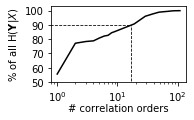

In [33]:
# fig.text(l_mrg+MI_shift+0.09*block_size,dens_y+dens_blockY+plot_height*1.5,
#         "     Mutual\n information \n    $\mathrm{I}(U_1,U_2)$",fontsize=16)
# trunc =  fig.add_axes([l_mrg + all_shift,b_mrg+2*dens_blockY,plot_width,plot_height])
fig = plt.figure(figsize=(2.5,1.5))
# ax0 = fig.add_axes([0,0,1,1])
trunc = fig.add_axes([0.245,0.28,0.75,0.70])
with open(f"{home}/results/HYgX_trunc_D1C.pkl","rb") as f:
    [NsC,xC,HC] = pkl.load(f)
Ns = 109-NsC
trunc.semilogx(Ns[:],[100*(H.mean()-Hs)/(HC[0].mean()-Hs) for H in HC[:]],color='k')
print([100*(H.mean()-Hs)/(HC[0].mean()-Hs) for H in HC[:]])
lines = [[(0, 90), (17, 90)], [(17, 0), (17, 90)]]
lc = mc.LineCollection(lines, colors='k', linestyle='dashed', linewidths=0.8)
trunc.add_collection(lc)
# trunc.semilogx(Ns[:-1],[100*H.mean()/HU[0].mean() for H in HU[:-1]])
# trunc.text(23,28,'28',fontweight='bold')
trunc.set_xlabel('# correlation orders',labelpad=0)
trunc.set_ylabel('% of all H($\mathbf{y}|x$)')
trunc.set_ylim(50,103)
trunc.set_yticks([50,60,70,80,90,100]);
fig.savefig(f"{home}/results/corr_order.pdf")